In [1]:
import pandas as pd
import numpy as np
import os
import re

## Loading data

In [2]:
# load data into pandas
def read_data(dir_path):
    examples = []
    for filename in os.listdir(dir_path):
        if not filename.endswith("txt"):
            continue
        keys = filename.split(".")[0].split("_")
        assert len(keys) == 3
        # keys is [id, label, review_score]. For now we are only interested in the label
        label = keys[1]
        with open(os.path.join(dir_path, filename)) as f:
            text = f.read().strip().replace("<br />", " ")
        examples.append([text, 1 if label == 'pos' else 0])
    return examples

In [165]:
DEV_SIZE = 1600

In [166]:
SDEV_DIR = '../imdb-data/sd{}'.format(DEV_SIZE)
sdev_data = read_data(SDEV_DIR)
sdev_df = pd.DataFrame(sdev_data, columns=['text', 'label'])
sdev_df

,text,label
0,It's beyond my comprehension that so much rubb...,1
1,Bonjour Tristesse covers similar ground as 'Th...,0
2,I have 2 words for you. Sean Bean. He is the o...,0
3,Big S isn't playing with taboos or forcing an ...,1
4,After seeing this film I complained to my loca...,0
...,...,...
1595,A wonderful early musical film from Rene Clair...,1
1596,"Nominated for the oscar ""worst script ever"" in...",0
1597,"A light-hearted comedy, Nothing shows us a wor...",1
1598,"This movie has its ups and downs, but to me th...",1


In [4]:
TRAIN_DIR = '../imdb-data/og'
train_data = read_data(TRAIN_DIR)
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
len(train_df)

,text,label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,1
2,First of all this was not a three hour movie -...,1
3,I cant understand at all why so many Godzilla ...,0
4,It's beyond my comprehension that so much rubb...,1
...,...,...
24995,This movie is about this wimpy guy who decides...,1
24996,**Warning! Spoilers Ahead!** This short is pa...,1
24997,I really enjoyed The 60's. Not being of that g...,1
24998,"While on a vacation at the beach, red-haired b...",0


## Run Naive Bayes on sdev set to generate keywords

In [5]:
from naive_bayes.imdb import return_keywords_indices

In [6]:
all_words, most_pos_indices, most_neg_indices = return_keywords_indices(sdev_data)

Size of dictionary:  4342


In [8]:
NUM_KEYWORDS = 50

top_pos_words = [all_words[ind] for ind in most_pos_indices[:NUM_KEYWORDS]]
top_neg_words = [all_words[ind] for ind in most_neg_indices[:NUM_KEYWORDS]]

In [11]:
print('Top pos words:')
print(top_pos_words)
print('\nTop neg words:')
print(top_neg_words)

# Remember to post-process these by removing those words that are correlational but not causal, e.g. 'germany'

Top pos words:
['eddie', 'stunning', 'ship', 'wonderful', 'shakespeare', 'hank', 'henry', 'professional', 'finest', 'watson', 'con', 'fate', 'germany', 'crowd', 'mclaglen', 'guilt', 'groups', 'technology', 'tremendous', 'genuine', 'crafted', 'refreshing', 'wonderfully', 'sullivan', 'jackie', 'segment', 'poignant', 'fay', 'teaches', 'captivating', 'gorgeous', 'favorites', 'hitman', 'gothic', 'mafia', 'kungfu', 'hoffman', 'superbly', 'innocence', 'peace', 'arrives', 'ethan', 'sexuality', 'develops', 'stayed', 'expensive', 'immensely', 'perfection', 'classical', 'beaten']

Top neg words:
['pointless', 'poorly', 'laughable', 'waste', 'thugs', 'mediocre', 'remotely', '310', 'drags', 'amateurish', 'cabin', 'zombies', 'worst', 'accents', '1972', 'bergman', 'garbage', 'blatantly', '210', 'cardboard', 'terrible', 'awful', 'lowbudget', 'wasting', 'incomprehensible', 'boll', 'horrible', 'morality', 'infected', 'attack', 'meaningless', 'horrendous', 'forgettable', 'painfully', 'flag', 'idiotic', '

## Labeling functions

In [12]:
# define constants to represent class labels
ABSTAIN = -1
POS = 1
NEG = 0

In [13]:
DISTANCE = 8

In [14]:
from snorkel.labeling import labeling_function

negative_inflection_words = ["but", "however", "otherwise"]
neg_adjs = set([
    'bad', 'worst', 'horrible', 'terrible', 'stupid', 'boring', 'dreadful', 'disgust',
    'disturbing', 'problem', 'disaster', 'a waste', 'not a fan'
])
pos_adjs = set([
  'good', 'best', 'great', 'awesome', 'perfect', 'clever', 'charming',
  'fascinating', 'pleasant', 'happy', 'hilarious', 'funny', 'wonderful', 'lovely'
])

pos_words = set(['stunning', 'wonderful', 'finest', 'professional', 'fate','crafted', 
                 'refreshing', 'tremendous', 'technology', 'genuine', 'wonderfully', 'favorites', 
                 'gorgeous', 'captivating', 'poignant', 
                 'segment', 'teaches', 'stayed', 'confronted', 
                 'perfection', 'peace', 'innocence', 'immensely', 'expensive',
                 'develops', 'covered', 'arrives', 'superbly', 'beaten'])

neg_words = set(['pointless', 'poorly', 'laughable', 'waste', 'mediocre',
                 'remotely', 'amateurish', 'drags', 'worst',
                 'blatantly', 'accents', 'garbage', 'terrible', 
                 'awful', 'wasting', 'lowbudget', 'horrible', 'infected',
                 'incomprehensible', 'attack', 'unwatchable', 'painfully',
                 'horrendous', 'forgettable', 'unfunny', 'pack', 'idiotic', 
                 'meaningless', 'zero', 'bland', 'crap', 'dire'])

@labeling_function()
def good(x):
    if re.search(r'not.{0,8}good', x.text.lower()):
        return NEG
    elif 'good' in x.text.lower():
        return POS
    return ABSTAIN

@labeling_function()
def bad(x):
    if re.search(r'not.{0,8}bad', x.text.lower()):
        return ABSTAIN
    elif 'bad' in x.text.lower():
        return NEG
    return ABSTAIN

@labeling_function()
def pos_adj(x):
    text = x.text.lower()

    for word in pos_adjs:
        char_index = text.find(word)
        if char_index != -1:
            substring = text[max(char_index - DISTANCE, 0):char_index]
            if ('not' in substring) or ('n\'t' in substring) :
                continue
            else:
                return POS
    return ABSTAIN


@labeling_function()
def neg_adj(x):
    text = x.text.lower()
    for word in neg_adjs:
        char_index = text.find(word)
        if char_index != -1:
            substring = text[max(char_index - DISTANCE, 0):char_index]
            if ('not' in substring) or ('n\'t' in substring) :
                continue
            else:
                return NEG
    return ABSTAIN


@labeling_function()
def detect_pos_words_from_naive_bayes(x):
    return POS if any(re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) \
                      for word in pos_words) else ABSTAIN
    #return POS if any(word in x.text.lower() for word in pos_words) else ABSTAIN

@labeling_function()
def detect_neg_words_from_naive_bayes(x):
    return NEG if any(re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) \
                      for word in neg_words) else ABSTAIN
    #return NEG if any(word in x.text.lower() for word in neg_words) else ABSTAIN
    
@labeling_function()    
def detect_pos_exclamation(x):
    return POS if all(not re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) for word in neg_words) \
                    and '!' in x.text.lower() else ABSTAIN
@labeling_function()                      
def detect_neg_exclamation(x):
    return NEG if all(not re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', x.text.lower()) for word in pos_words) \
                    and '!' in x.text.lower() else ABSTAIN

@labeling_function()
def score_keywords(x):
    text = x.text.lower()
    pos_word_score = 1.0
    neg_word_score = -1.0
    score = 0
    for word in pos_words:
        if re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', text):
            score += pos_word_score
    for word in neg_words:
        if re.search(r'[.!?\-\s]' + word + r'[.!?\-\s]', text):
            score += neg_word_score
    if score > 0:
        return POS
    elif score < 0:
        return NEG
    return ABSTAIN

## Applying and tuning LFs

In [115]:
lfs = [neg_adj, 
       detect_pos_words_from_naive_bayes, detect_neg_words_from_naive_bayes,
       detect_pos_exclamation, score_keywords]

In [116]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

applier = PandasLFApplier(lfs=lfs)

In [117]:
L_sdev = applier.apply(df=sdev_df)
LFAnalysis(L=L_sdev, lfs=lfs).lf_summary(Y=np.asarray(sdev_df["label"]))


100%|██████████| 1600/1600 [00:08<00:00, 179.79it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
neg_adj,0,[0],0.451875,0.329375,0.093125,508,215,0.702628
detect_pos_words_from_naive_bayes,1,[1],0.175625,0.175625,0.065625,254,27,0.903915
detect_neg_words_from_naive_bayes,2,[0],0.321875,0.321875,0.024375,456,59,0.885437
detect_pos_exclamation,3,[1],0.198125,0.085000,0.051875,241,76,0.760252
score_keywords,4,"[0, 1]",0.460625,0.460625,0.053125,686,51,0.930801


In [118]:
L_train = applier.apply(df=train_df)
LFAnalysis(L=L_train, lfs=lfs).lf_summary()


 12%|█▏        | 2978/25000 [00:15<02:02, 179.26it/s]


 25%|██▍       | 6161/25000 [00:31<01:40, 186.63it/s]


 37%|███▋      | 9271/25000 [00:46<01:03, 249.08it/s]


 50%|████▉     | 12400/25000 [01:02<01:04, 195.20it/s]


 62%|██████▏   | 15547/25000 [01:18<00:53, 177.82it/s]


 75%|███████▍  | 18742/25000 [01:34<00:26, 232.29it/s]


 89%|████████▊ | 22131/25000 [01:50<00:12, 235.99it/s]


100%|██████████| 25000/25000 [02:05<00:00, 199.32it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
neg_adj,0,[0],0.44492,0.33788,0.12612
detect_pos_words_from_naive_bayes,1,[1],0.19572,0.19572,0.09172
detect_neg_words_from_naive_bayes,2,[0],0.32976,0.32976,0.05192
detect_pos_exclamation,3,[1],0.21528,0.10012,0.06520
score_keywords,4,"[0, 1]",0.44384,0.44384,0.06200


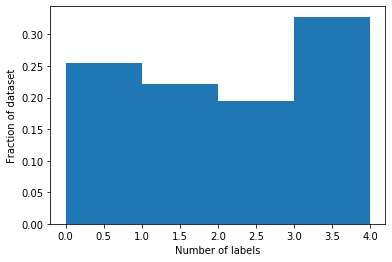

In [138]:
import matplotlib.pyplot as plt
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## Testing Majority Vote (baseline) on sdev set

In [119]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
majority_acc = majority_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   83.0%


In [120]:
# Attention: this part is pseudo-cheating!

majority_model_test_acc = majority_model.score(L=L_train, Y=np.asarray(train_df["label"]))["accuracy"]
print(f"{'Majority Vote ~TEST~ Accuracy:':<25} {majority_model_test_acc * 100:.1f}%")

Majority Vote ~TEST~ Accuracy: 77.6%


## Training Generative Model on train set and testing it on sdev set

In [151]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2)
label_model.fit(L_train=L_train, n_epochs=50, lr=.001, log_freq=1)

In [153]:
label_model_acc = label_model.score(L=L_sdev, Y=np.asarray(sdev_df["label"]))["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     80.9%


In [154]:
# Attention: this part is pseudo-cheating!

label_model_test_acc = label_model.score(L=L_train, Y=np.asarray(train_df["label"]))["accuracy"]
print(f"{'Label Model ~TEST~ Accuracy:':<25} {label_model_test_acc * 100:.1f}%")

Label Model ~TEST~ Accuracy: 75.6%


## Filtering out unlabeled data points

In [155]:
from snorkel.labeling import filter_unlabeled_dataframe

In [156]:
model = label_model

### Filter

In [157]:
probs_train = model.predict_proba(L=L_train)

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=train_df, y=probs_train, L=L_train
)

## Export dataframe

In [158]:
df_train_filtered

,text,label
0,I have to start saying it has been a long time...,1
1,I thought that Mukhsin has been wonderfully wr...,1
2,First of all this was not a three hour movie -...,1
3,I cant understand at all why so many Godzilla ...,0
4,It's beyond my comprehension that so much rubb...,1
...,...,...
24994,I agree with other users comments in that the ...,0
24995,This movie is about this wimpy guy who decides...,1
24996,**Warning! Spoilers Ahead!** This short is pa...,1
24997,I really enjoyed The 60's. Not being of that g...,1


In [168]:
export_path = '../imdb-data/wd{}.csv'.format(DEV_SIZE)
df_train_filtered.to_csv(export_path, header=False, index=False)